Cargo las librerías:

In [1]:
import pandas as pd
import numpy as np
import time
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression

Cargo los datos:

In [2]:
X_train = pd.read_csv('X_train_ns.csv')
del X_train['Unnamed: 0']
y_train = pd.read_csv('log_y_train.csv')
del y_train['Unnamed: 0']

Realizo una división entre conjunto de entrenamiento y conjunto de validación:

In [3]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.1,
                                                    # Asigno la fecha de hoy como random_state
                                                    random_state=1062022)

X_train2.shape, X_val.shape

((11957, 50), (1329, 50))

## Baseline

Creo un modelo de Random Forest para usar como baseline:

In [4]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, bootstrap = True,
                               random_state = 100, criterion = 'squared_error',
                               ccp_alpha = 0.00025, max_samples = 0.1,
                               max_features=12)

In [5]:
model.fit(X = X_train2, y = y_train2)
Preds_train = model.predict(X_train2)
Preds_val = model.predict(X_val)

<ipython-input-5-f23e0ca025a3>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X = X_train2, y = y_train2)


El error sobre el conjunto de entrenamiento es:

In [6]:
sk.metrics.mean_squared_error(Preds_train, y_train2)

0.11749491125839087

El error sobre el conjunto de validación es:

In [7]:
sk.metrics.mean_squared_error(Preds_val, y_val)

0.15152903155492428

Gráfico de las predicciones sobre train:

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


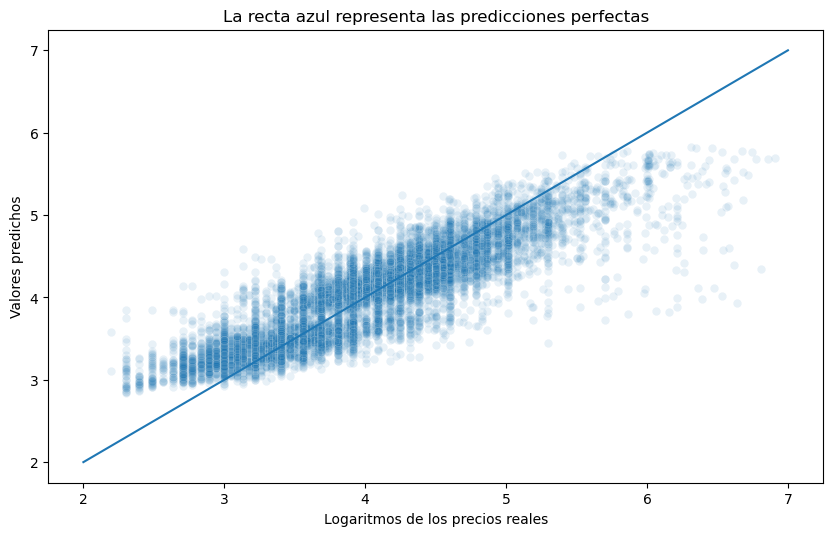

In [8]:
objetivo = list(list(np.array(y_train2).reshape(1,-1))[0])

plt.figure(dpi=100, figsize=(10, 6))
sns.scatterplot(objetivo,list(Preds_train),alpha=0.1)
plt.plot((2,7), (2,7))

plt.title("La recta azul representa las predicciones perfectas")
plt.xlabel('Logaritmos de los precios reales')
plt.ylabel('Valores predichos')
plt.show()

La acumulación en columnas de los precios en el gráfico se debe a que los precios reales suelen ser enteros.

Gráfico de las predicciones sobre validación:

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


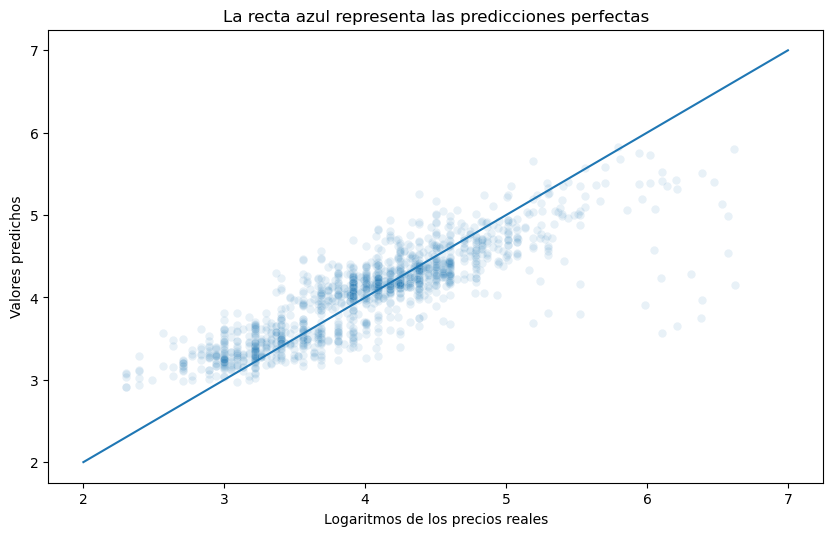

In [9]:
objetivo = list(list(np.array(y_val).reshape(1,-1))[0])

plt.figure(dpi=100, figsize=(10, 6))
sns.scatterplot(objetivo,list(Preds_val),alpha=0.1)
plt.plot((2,7), (2,7))

plt.title("La recta azul representa las predicciones perfectas")
plt.xlabel('Logaritmos de los precios reales')
plt.ylabel('Valores predichos')
plt.show()

## Optimización de los parámetros del modelo

Empleo GridSearch para tratar de mejorar los parámetros. En un primer GridSearch, pruebo parámetros muy separados entre sí, para buscar en que zona del espacio paramétrico esta el modelo más óptimo:

In [10]:
t1 = time.time()

model = RandomForestRegressor()

param_grid = {'n_estimators': [100], 'n_jobs': [-1], 'bootstrap': [True],
                               'random_state': [100], 'criterion': ['squared_error'],
              
                               'ccp_alpha': [0.00001,0.00025,0.001],
                               'max_samples': [0.1,0.5,1],
                               'max_features': [6,12,30]}

cv = GridSearchCV(model, param_grid, n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

cv.fit(X_train, y_train)

print(cv.best_estimator_)

print(cv.best_score_)

print('Se han tardado',time.time()-t1,'segundos.')

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestRegressor(ccp_alpha=1e-05, max_features=30, max_samples=0.5,
                      n_jobs=-1, random_state=100)
-0.11813240789270671
Se han tardado 87.76776194572449 segundos.


En un segundo GridSearch hago una búsqueda más detallada por la zona del espacio paramétrico en la que sé, gracias al primer GridSearch, que está el modelo:

In [11]:
t1 = time.time()

model = RandomForestRegressor()

param_grid = {'n_estimators': [100], 'n_jobs': [-1], 'bootstrap': [True],
                               'random_state': [100], 'criterion': ['squared_error'],
              
                               'ccp_alpha': [0,0.00001],
                               'max_samples': [0.3,0.5,0.7],
                               'max_features': [35,40,45]}

cv = GridSearchCV(model, param_grid, n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

cv.fit(X_train, y_train)

print(cv.best_estimator_)

print(cv.best_score_)

print('Se han tardado',time.time()-t1,'segundos.')

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestRegressor(ccp_alpha=0, max_features=35, max_samples=0.7, n_jobs=-1,
                      random_state=100)
-0.1163790400015012
Se han tardado 225.42901635169983 segundos.


Defino el modelo óptimo (según los GridSearch que he realizado), lo entreno y lo empleo para realizar predicciones sobre los conjuntos de entrenamiento y validación:

In [12]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, bootstrap = True,
                               random_state = 100, criterion = 'squared_error',
                               ccp_alpha = 0, max_samples = 0.7,
                               max_features=35)

In [13]:
model.fit(X = X_train2, y = y_train2)
Preds_train = model.predict(X_train2)
Preds_val = model.predict(X_val)

<ipython-input-13-f23e0ca025a3>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X = X_train2, y = y_train2)


El error cuadrático medio sobre el conjunto de entrenamiento es:

In [14]:
sk.metrics.mean_squared_error(Preds_train, y_train2)

0.027758991216110876

El error cuadrático medio sobre el conjunto de validación es:

In [15]:
sk.metrics.mean_squared_error(Preds_val, y_val)

0.12311639750198658

Gráfico de las predicciones sobre train:

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


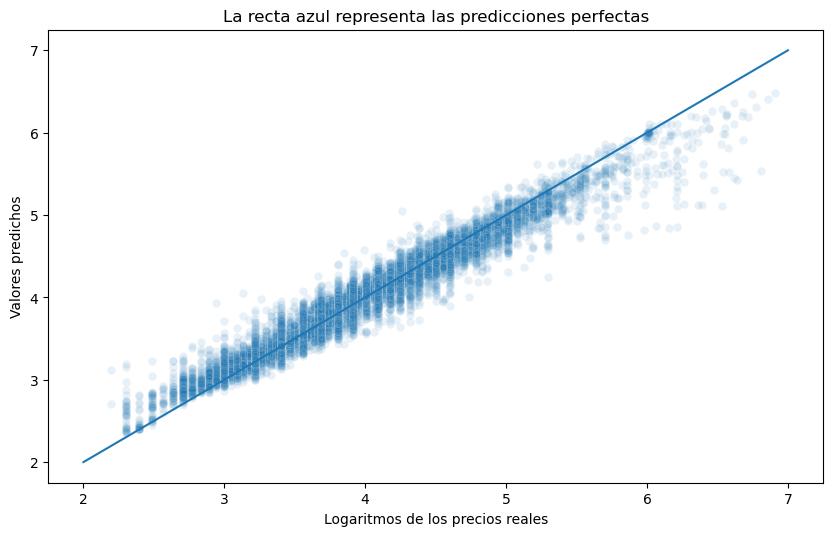

In [17]:
objetivo = list(list(np.array(y_train2).reshape(1,-1))[0])

plt.figure(dpi=100, figsize=(10, 6))
sns.scatterplot(objetivo,list(Preds_train),alpha=0.1)
plt.plot((2,7), (2,7))

plt.title("La recta azul representa las predicciones perfectas")
plt.xlabel('Logaritmos de los precios reales')
plt.ylabel('Valores predichos')
plt.show()

Gráfico de las predicciones sobre el conjunto de validación:

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


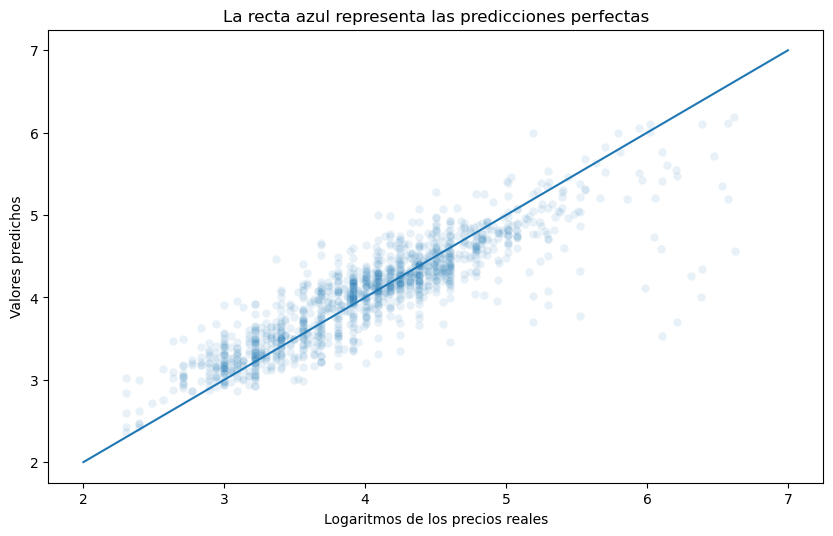

In [18]:
objetivo = list(list(np.array(y_val).reshape(1,-1))[0])

plt.figure(dpi=100, figsize=(10, 6))
sns.scatterplot(objetivo,list(Preds_val),alpha=0.1)
plt.plot((2,7), (2,7))

plt.title("La recta azul representa las predicciones perfectas")
plt.xlabel('Logaritmos de los precios reales')
plt.ylabel('Valores predichos')
plt.show()

Los resultados son significativamente mejores que después de aplicar GridSearch.

## Importancia de las variables

Una ventaja de los modelos de árboles de decisión, o de ensamblado de árboles de decisión (como en este caso), es que se puede extraer la importancia que da el modelo a cada variable. Esto es interesante de cara tanto a la interpretación como la selección de variables.

Primero voy a extraer la información mutua de cada variable, para compararla con las importancias que el modelo de a las variables:

In [19]:
def Información_Mutua(X, y):
    '''
    X debe ser un DataFrame con las variables predictivas.
    y debe contener la variable objetivo.
    '''
    # Calculo el mutual information,
    # y ordeno las variables según el mutual information:
    
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Valores de la información mutua por variable:

In [20]:
I_M = Información_Mutua(X_train, y_train)
I_M[::]

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PCA2_v2                                                  0.517109
PCA2                                                     0.373901
Accommodates                                             0.370319
Room Type                                                0.358504
Cluster                                                  0.301474
Host Listings Count                                      0.240849
Bedrooms                                                 0.239398
Calculated host listings count                           0.233889
Host Total Listings Count                                0.227436
Beds                                                     0.219935
PCA4                                                     0.161641
Zona                                                     0.160226
Guests Included                                          0.157490
Bathrooms                                                0.139587
PCA5                                                     0.127511
PCA1      

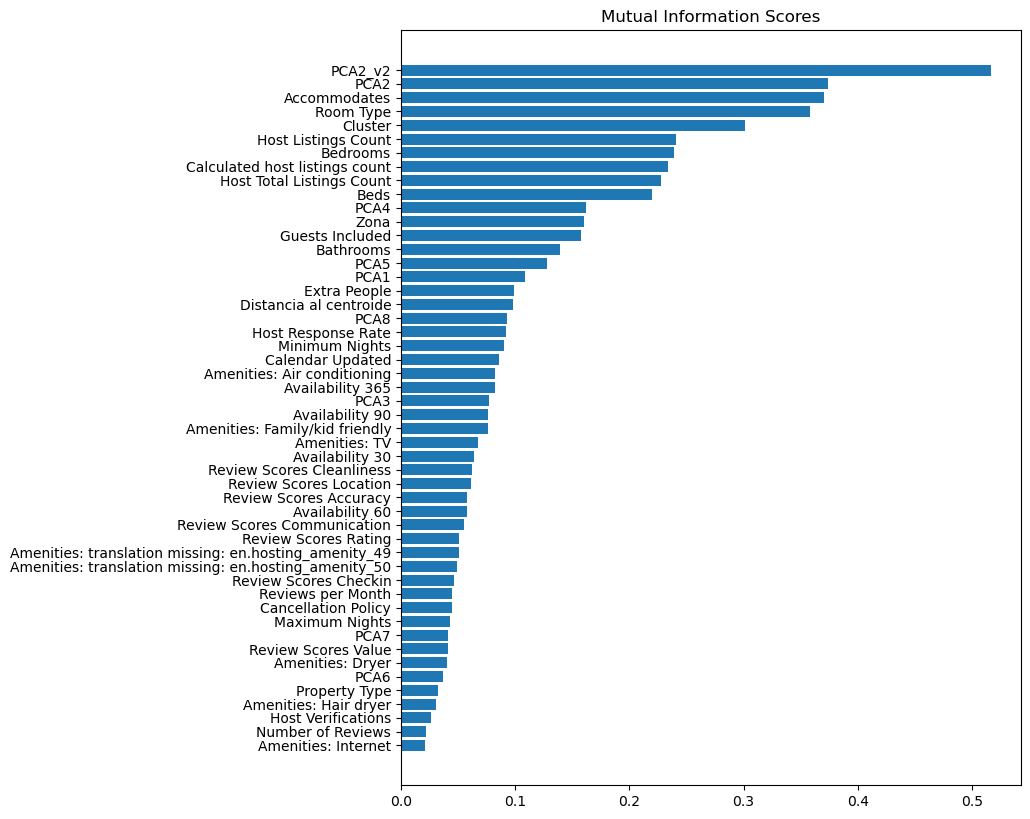

In [23]:
plt.figure(dpi=100, figsize=(8, 10))
plot_mi_scores(I_M)

Como se puede ver comparando el gráfico anterior (Información Mutua) y siguiente (importancia que el modelo de Random Forest da a las características), la importancia que una variable tiene en un Random Forest no esta determinada sólo por su Información Mutua, sino también por otros factores, como si tiene interacciones informativas con otras variables predictoras:

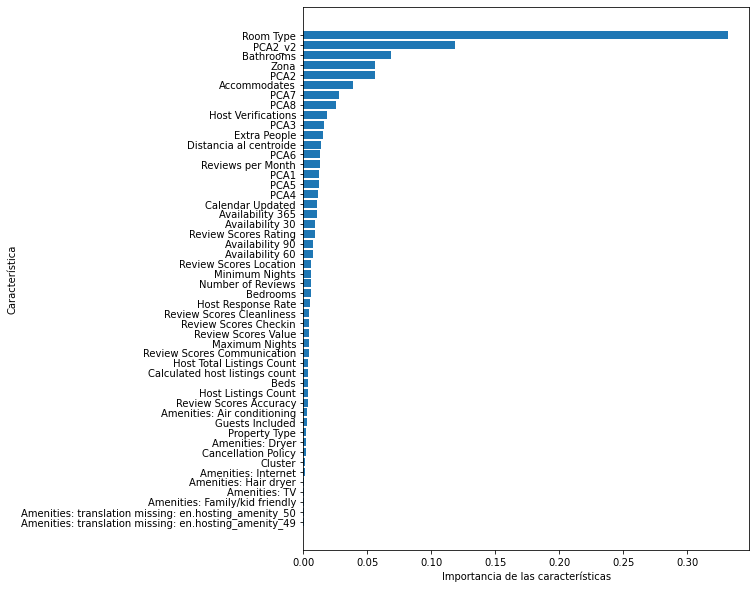

In [22]:
plt.figure(figsize=(8, 10))
plt.barh(range(50), model.feature_importances_[np.argsort(model.feature_importances_)])
plt.yticks(np.arange(50),X_train.columns[np.argsort(model.feature_importances_)])
plt.xlabel('Importancia de las características')
plt.ylabel('Característica')
plt.show()

## Interpretación

Del gráfico anterior se puede interpretar que las siguientes variables son las más importantes para predecir el precio de un piso:
- Room Type: ¿Tiene el huésped una habitación compartida, una habitación individual, o alquila toda la casa?
- Bathrooms: Número de servicios.
- Zona: Cúal es el precio medio del alquiler en la zona del piso.

Mientras que otras variables, como si el apartamento tiene televisión o no("Amenities: TV"), son prácticamente irrelevantes de cara al precio del alojamiento.

## Selección de variables

Las variables más importantes para el modelo son las siguientes:

In [24]:
A = list(X_train.columns[np.argsort(model.feature_importances_)])
A.reverse()
A = A[0:11]
X_train2.loc[:,A].head()

,Room Type,PCA2_v2,Bathrooms,Zona,PCA2,Accommodates,PCA7,PCA8,Host Verifications,PCA3,Extra People
3464,-1.146993,-0.442352,-0.426216,-0.619574,-0.511202,-0.609782,0.316420,-0.250619,-1.647800,0.809394,0.205250
8331,0.781988,0.385831,-0.426216,0.280337,1.067494,0.349380,1.181711,-0.514645,-0.091707,-0.188065,1.483746
4185,-1.146993,-0.384875,1.098520,-1.253422,-0.937794,-0.609782,0.094392,-0.030480,-0.091707,1.143384,-0.647081
9,0.781988,-0.017810,-0.426216,0.280337,-0.062988,0.828961,0.573274,-0.074656,1.464385,0.409943,-0.647081
3251,-1.146993,-0.298661,-0.426216,-1.140846,-0.488052,0.349380,-1.317828,-1.264692,-0.869753,1.410417,0.205250


## Optimización del nuevo modelo

Voy a crear un modelo de Random Forest únicamente con estas variables, para ver si de esta forma el modelo mejora.

Busco el modelo óptimo utilizando 3 GridSearchs. La idea es empezar con un Grid de poca precisión, y después ir reduciendo la anchura del Grid según se va acotando la zona del espacio paramétrico en que esta el modelo óptimo.

In [25]:
t1 = time.time()

model = RandomForestRegressor()

param_grid = {'n_estimators': [100], 'n_jobs': [-1], 'bootstrap': [True],
                               'random_state': [100], 'criterion': ['squared_error'],
              
                               'ccp_alpha': [0,0.00001,0.00025],
                               'max_samples': [0.3,0.5,0.7,1],
                               'max_features': [1,3,4,11]}

cv = GridSearchCV(model, param_grid, n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

cv.fit(X_train, y_train)

print(cv.best_estimator_)

print(cv.best_score_)

print('Se han tardado',time.time()-t1,'segundos.')

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestRegressor(ccp_alpha=0, max_features=11, max_samples=0.7, n_jobs=-1,
                      random_state=100)
-0.11997457846527779
Se han tardado 113.49642729759216 segundos.


In [26]:
t1 = time.time()

model = RandomForestRegressor()

param_grid = {'n_estimators': [100], 'n_jobs': [-1], 'bootstrap': [True],
                               'random_state': [100], 'criterion': ['squared_error'],
              
                               'ccp_alpha': [0],
                               'max_samples': [0.6,0.7,0.8],
                               'max_features': [7,9,11]}

cv = GridSearchCV(model, param_grid, n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

cv.fit(X_train, y_train)

print(cv.best_estimator_)

print(cv.best_score_)

print('Se han tardado',time.time()-t1,'segundos.')

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestRegressor(ccp_alpha=0, max_features=11, max_samples=0.8, n_jobs=-1,
                      random_state=100)
-0.11877520712761716
Se han tardado 27.378345251083374 segundos.


In [27]:
t1 = time.time()

model = RandomForestRegressor()

param_grid = {'n_estimators': [100], 'n_jobs': [-1], 'bootstrap': [True],
                               'random_state': [100], 'criterion': ['squared_error'],
              
                               'ccp_alpha': [0],
                               'max_samples': [0.8,0.9],
                               'max_features': [9,10,11]}

cv = GridSearchCV(model, param_grid, n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

cv.fit(X_train, y_train)

print(cv.best_estimator_)

print(cv.best_score_)

print('Se han tardado',time.time()-t1,'segundos.')

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestRegressor(ccp_alpha=0, max_features=11, max_samples=0.9, n_jobs=-1,
                      random_state=100)
-0.11842531684638999
Se han tardado 25.39418363571167 segundos.


Es decir, en este caso, Bagging es preferible a Random Forest. La diferencia entre Bagging y Random Forest es que en Bagging no se limita el número de variables a usar en cada árbol, con lo que un Random Forest en que el número máximo de variables a usar en cada árbol es el número total de variables es, de hecho, un modelo de Bagging.

Defino y entreno el modelo, y veo los errores de sus predicciones:

In [28]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, bootstrap = True,
                               random_state = 100, criterion = 'squared_error',
                               ccp_alpha = 0, max_samples = 0.9,
                               max_features=11)

In [29]:
model.fit(X = X_train2.loc[:,A], y = y_train2)
Preds_train = model.predict(X_train2.loc[:,A])
Preds_val = model.predict(X_val.loc[:,A])

<ipython-input-29-ed1bec576a61>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X = X_train2.loc[:,A], y = y_train2)


Error cuadrático medio sobre train:

In [30]:
sk.metrics.mean_squared_error(Preds_train, y_train2)

0.020034288630870662

Error cuadrático medio sobre validación:

In [31]:
sk.metrics.mean_squared_error(Preds_val, y_val)

0.1277471144264671

Aunque el GridSearch determine que emplear todas las variables en cada árbol es preferible, no emplear todas las variables en cada árbol suele llevar a mejores modelos porque aumenta la varianza entre los árboles del Random Forest, lo que reduce la varianza de la predicción del Random Forest. En consecuencia, pruebo a emplear sólo 10 variables como máximo en cada árbol, en lugar de 11 (que es el número máximo de variables):

In [32]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, bootstrap = True,
                               random_state = 100, criterion = 'squared_error',
                               ccp_alpha = 0, max_samples = 0.9,
                               max_features=10)

model.fit(X = X_train2.loc[:,A], y = y_train2)
Preds_train = model.predict(X_train2.loc[:,A])
Preds_val = model.predict(X_val.loc[:,A])

<ipython-input-32-8aafdccd0952>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X = X_train2.loc[:,A], y = y_train2)


Error cuadrático medio sobre train:

In [33]:
sk.metrics.mean_squared_error(Preds_train, y_train2)

0.019901991988663655

Error cuadrático medio sobre validación:

In [34]:
sk.metrics.mean_squared_error(Preds_val, y_val)

0.12772230959096553

El error cuadrático medio sobre el conjunto de validación es ligaramente menor, pero prácticamente el mismo. El motivo por el que el resultado obtenido por GridSearch es distinto es porque cuando se testean modelos usando Cross Validation (la implementación de GridSearch que yo he empleado usa Cross Validation) o un conjunto de validación, siempre hay una varianza asociada.

En consecuencia, el modelo extraído por GridSearch y este, en la práctica, seguramente son igual de eficaces.

Elijo este último porque reducir el número de variables por árbol puede ayudar a evitar sobreajustes.

Por este mismo motivo pruebo a añadir un pequeño grado de cost-complexity pruning (para evitar sobreajustes):

In [38]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, bootstrap = True,
                               random_state = 100, criterion = 'squared_error',
                               ccp_alpha = 1e-5, max_samples = 0.9,
                               max_features=10)

model.fit(X = X_train2.loc[:,A], y = y_train2)
Preds_train = model.predict(X_train2.loc[:,A])
Preds_val = model.predict(X_val.loc[:,A])

<ipython-input-38-2806523dcdd7>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X = X_train2.loc[:,A], y = y_train2)


Error cuadrático medio sobre train:

In [39]:
sk.metrics.mean_squared_error(Preds_train, y_train2)

0.025726944395318422

Error cuadrático medio sobre validación:

In [40]:
sk.metrics.mean_squared_error(Preds_val, y_val)

0.1275826472943675

El error sobre el conjunto de validación es mejor que el error del modelo hallado por Grid Search (por los motivos antes explicados, esto no es una contradicción).

En consecuencia, me decanto por este último modelo.

Gráfico de las predicciones sobre train:

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


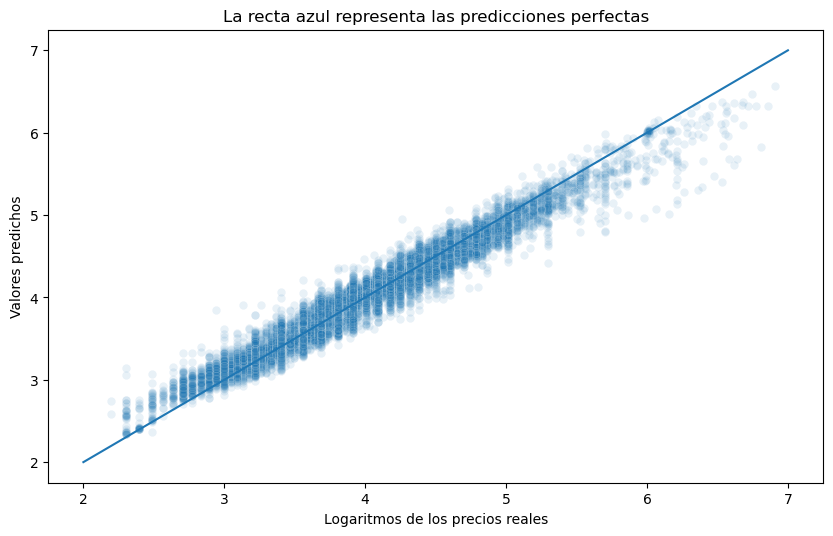

In [41]:
objetivo = list(list(np.array(y_train2).reshape(1,-1))[0])

plt.figure(dpi=100, figsize=(10, 6))
sns.scatterplot(objetivo,list(Preds_train),alpha=0.1)
plt.plot((2,7), (2,7))

plt.title("La recta azul representa las predicciones perfectas")
plt.xlabel('Logaritmos de los precios reales')
plt.ylabel('Valores predichos')
plt.show()

Gráfico de las predicciones sobre test:

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


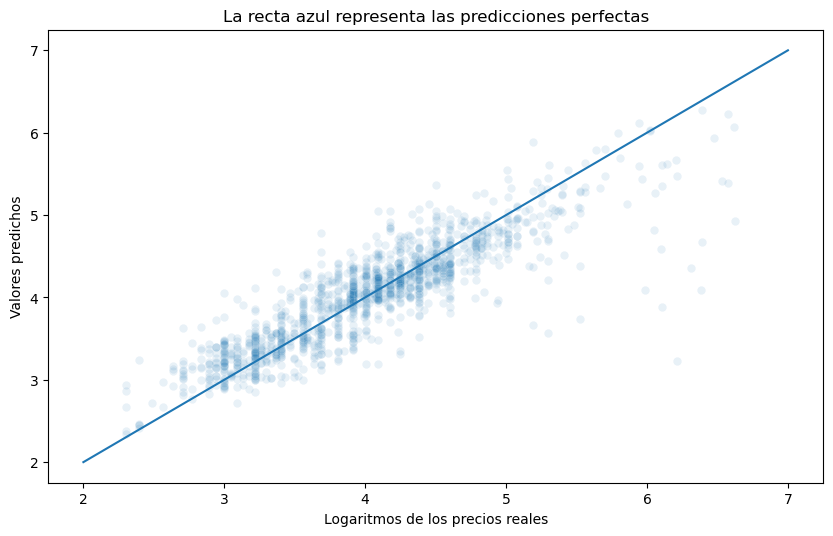

In [42]:
objetivo = list(list(np.array(y_val).reshape(1,-1))[0])

plt.figure(dpi=100, figsize=(10, 6))
sns.scatterplot(objetivo,list(Preds_val),alpha=0.1)
plt.plot((2,7), (2,7))

plt.title("La recta azul representa las predicciones perfectas")
plt.xlabel('Logaritmos de los precios reales')
plt.ylabel('Valores predichos')
plt.show()

Finalmente he hecho dos modelos de Random Forest, uno que emplea todas las variables y otro que emplea sólo 11.

El que emplea más variables padece de ligeramente menos overfitting (a pesar de emplear más variables) por que:
- Su error sobre test es ligeramente menor.
- Su error sobre train es ligeramente mayor.
- La proporción de observaciones que emplea para entrenar cada árbol es menor.
- La proporción de variables que emplea en cada árbol es menor.

Sin embargo, es difícil decantarse por un modelo u otro, así que probaré ambos sobre el conjunto de test.

Guardo la selección de variables del segundo modelo:

In [43]:
X_sel = X_train.loc[:,A]
X_sel.head()

,Room Type,PCA2_v2,Bathrooms,Zona,PCA2,Accommodates,PCA7,PCA8,Host Verifications,PCA3,Extra People
0,0.781988,0.965820,-0.426216,-1.070992,0.399844,1.308542,-0.030524,-0.221199,-0.869753,-0.578555,0.205250
1,0.781988,0.918794,0.336152,2.030536,1.391361,0.828961,1.341455,1.123184,-0.869753,1.373258,0.205250
2,-1.146993,-0.458027,1.098520,0.137019,-0.193042,-1.089363,-0.175337,-0.497616,2.242432,-0.012053,-0.647081
3,0.781988,-0.370506,-0.426216,0.280337,-0.679870,-0.609782,2.103483,1.052847,0.686339,-0.054172,-0.647081
4,-1.146993,-0.549467,-0.426216,0.332816,-0.768773,-1.089363,0.031287,-1.047214,0.686339,0.866485,-0.647081


In [47]:
Seleccion_Optima = pd.Series(X_sel.columns)

In [49]:
#pd.Series(Seleccion_Optima).to_csv('Variables_Random_Forest.csv')

La información mutua de las variables seleccionadas es:

In [44]:
I_M = Información_Mutua(X_sel, y_train)
I_M[::]

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PCA2_v2               0.523508
PCA2                  0.372278
Accommodates          0.365905
Room Type             0.363873
Zona                  0.151873
Bathrooms             0.140570
Extra People          0.108505
PCA8                  0.093097
PCA3                  0.076077
Host Verifications    0.047155
PCA7                  0.040268
Name: MI Scores, dtype: float64

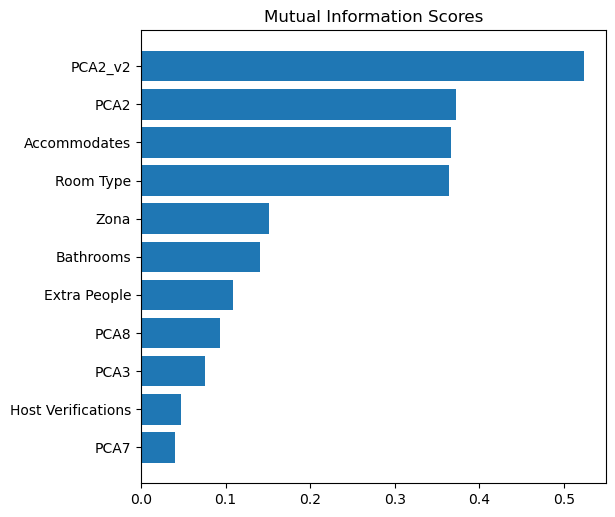

In [45]:
plt.figure(dpi=100, figsize=(6, 6))
plot_mi_scores(I_M)

Y la importancia que les da el modelo de Random Forest es:

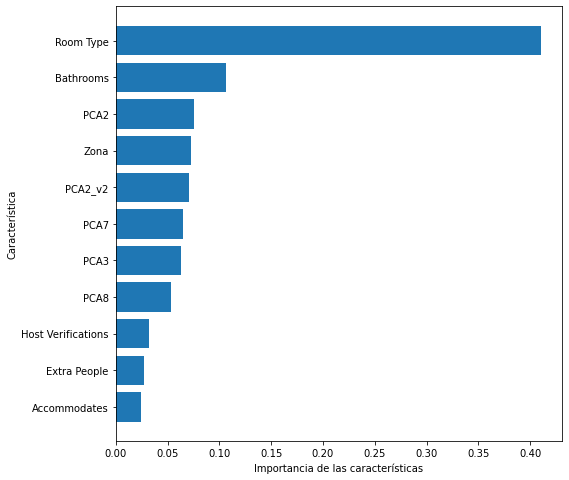

In [46]:
plt.figure(figsize=(8, 8))
plt.barh(range(11), model.feature_importances_[np.argsort(model.feature_importances_)])
plt.yticks(np.arange(11),X_train.loc[:,A].columns[np.argsort(model.feature_importances_)])
plt.xlabel('Importancia de las características')
plt.ylabel('Característica')
plt.show()